In [30]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

import string
alphabet=list(string.ascii_lowercase)


In [31]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Read in Data

In [32]:
ctrl={}
case={}

ctrl['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'
ctrl['machine_target']='gfdl.ncrc4-intel19-prod'
ctrl['name']='OM4p5_CORE2_IAF_gzCOBALT-013022_cy5';case['label']='Control'

case['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2'
case['machine_target']='gfdl.ncrc4-intel19-prod'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_cy5';case['label']='Tunicate'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy5';case['label']='Combined'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-hp_cy5';case['label']='Fish'


In [33]:
short_casename=case['name'].replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-060822":
    fig_casename='gzCOBALT-tun_cy1'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-hp_cy5 gzCOBALT-hp_cy5


In [34]:
phyto_varlist = ['di', 'smp', 'lgp']
zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [35]:
tmpdir = '/work/Jessica.Luo/tmp/'+case['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-hp_cy5


In [36]:
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_year_z'] 


pp_dates=['1988-2007','2048-2067']

files=[glob(tmpdir + '/'+ d + '.' + pp_dates[0] + '*.nc') for d in diagTypes]
if not files:
    files=[glob(tmpdir + '/'+ d + '.' + pp_dates[1] + '*.nc') for d in diagTypes]
files=sorted([f for fi in files for f in fi]) # nested list comprehension
print(files)

['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-hp_cy5/ocean_cobalt_omip_tracers_year_z.1988-2007.nc']


In [37]:
tmpdir = '/work/Jessica.Luo/tmp/'+ctrl['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)
    
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_year_z'] 

c_pp_dates='1988-2007'

c_files=[glob(tmpdir + '/'+ d + '.' + c_pp_dates + '*.nc') for d in diagTypes]
c_files=sorted([f for fi in c_files for f in fi]) # nested list comprehension

print(c_files)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5
['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5/ocean_cobalt_omip_tracers_year_z.1988-2007.nc']


In [38]:
dc=xr.open_mfdataset(c_files, combine='by_coords')

In [39]:
grid_file=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')+'/ocean_annual/ocean_annual.static.nc'
ds=xr.open_dataset(files[0])
grid=xr.open_dataset(grid_file)

In [40]:
ds['depth_levels']=xr.DataArray(ds.z_i.diff(dim='z_i').values, coords={'z_l':ds.z_l.values}, dims=['z_l'], attrs={'long_name':'Thickness of depth bin', 'units':'meters'})

In [41]:
import string
alphabet=list(string.ascii_lowercase)

### Models

In [42]:
# Get values at 500 m only; convert to mmol m-3; make 20-yr mean out of annual data
ds = ds.sel(z_l=500.).mean(dim='time')
ds['no3'].values = ds['no3'].values * 1e3 # unit conversion to mmol m-3
ds.no3.attrs['units'] = 'mmol m-3'

#o2
ds['o2'].values = ds['o2'].values * 1e3 # unit conversion to mmol m-3
ds.o2.attrs['units'] = 'mmol m-3'

#po4
ds['po4'].values = ds['po4'].values * 1e3 # unit conversion to mmol m-3
ds.po4.attrs['units'] = 'mmol m-3'


In [43]:
# Get values at 500 m only; convert to mmol m-3; make 20-yr mean out of annual data
dc = dc.sel(z_l=500.).mean(dim='time')
dc['no3'].values = dc['no3'].values * 1e3 # unit conversion to mmol m-3
dc.no3.attrs['units'] = 'mmol m-3'

#o2
dc['o2'].values = dc['o2'].values * 1e3 # unit conversion to mmol m-3
dc.o2.attrs['units'] = 'mmol m-3'

#po4
dc['po4'].values = dc['po4'].values * 1e3 # unit conversion to mmol m-3
dc.po4.attrs['units'] = 'mmol m-3'


### Observations

In [44]:
# Nitrate
no3_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/nitrate_woa18_esm4grid.nc'
no3_obs = xr.open_dataset(no3_obs_file)
no3_obs = no3_obs.sel(z_l=500.)

# Oxygen, units of µmol/kg
o2_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/O2_woa18_esm4grid.nc'
o2_obs = xr.open_dataset(o2_obs_file)
o2_obs = o2_obs.sel(z_l=500.)

# Phosphate
po4_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/phosphate_woa18_esm4grid.nc'
po4_obs = xr.open_dataset(po4_obs_file)
po4_obs = po4_obs.sel(z_l=500.)


# Evaluate Skill Metrics

In [45]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [46]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

### GZ-COBALT simulation

In [47]:
# Calculate N*

N_star = ds.no3 - 16.0*ds.po4
N_star_obs = no3_obs.nitrate_woa18 - 16.0*po4_obs.phosphate_woa18

In [48]:
# Annual means, Nitrate
# GZ-COBALT
X=ds.no3.stack(z=('xh','yh')).values
Y=no3_obs.nitrate_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_no3 = X[mask] - Y[mask]
res2_no3 = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_no3 = stats.skew(res1_no3)
skew2_no3 = stats.skew(res2_no3)
res_no3 = res1_no3
r_no3 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_no3 = rmse_diffs(res_no3)
bias_no3 = np.mean(res_no3)

In [49]:
# Annual means, Oxygen
X=ds.o2.stack(z=('xh','yh')).values
Y=o2_obs.O2_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_o2 = X[mask] - Y[mask]
res2_o2 = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_o2 = stats.skew(res1_o2)
skew2_o2 = stats.skew(res2_o2)
res_o2 = res1_o2
r_o2 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_o2 = rmse_diffs(res_o2)
bias_o2 = np.mean(res_o2)

In [50]:
# Annual means, Phosphate
X=ds.po4.stack(z=('xh','yh')).values
Y=po4_obs.phosphate_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_po4 = X[mask] - Y[mask]
res2_po4 = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_po4 = stats.skew(res1_po4)
skew2_po4 = stats.skew(res2_po4)
res_po4 = res1_po4
r_po4 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_po4 = rmse_diffs(res_po4)
bias_po4 = np.mean(res_po4)

In [51]:
# N*
X=N_star.stack(z=('xh','yh')).values
Y=N_star_obs.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_N_star = X[mask] - Y[mask]
res2_N_star = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_N_star = stats.skew(res1_N_star)
skew2_N_star = stats.skew(res2_N_star)
res_N_star = res1_N_star
r_N_star = stats.pearsonr(X[mask],Y[mask])[0]
rmse_N_star = rmse_diffs(res_N_star)
bias_N_star = np.mean(res_N_star)

### Control simulation

In [52]:
# Annual means, Nitrate
X=dc.no3.stack(z=('xh','yh')).values
Y=no3_obs.nitrate_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_c_no3 = X[mask] - Y[mask]
res2_c_no3 = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_c_no3 = stats.skew(res1_c_no3)
skew2_c_no3 = stats.skew(res2_c_no3)
res_c_no3 = res1_c_no3
r_c_no3 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_c_no3 = rmse_diffs(res_c_no3)
bias_c_no3 = np.mean(res_c_no3)

In [53]:
# Annual means, Oxygen
X=dc.o2.stack(z=('xh','yh')).values
Y=o2_obs.O2_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_c_o2 = X[mask] - Y[mask]
res2_c_o2 = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_c_o2 = stats.skew(res1_c_o2)
skew2_c_o2 = stats.skew(res2_c_o2)
res_c_o2 = res1_c_o2
r_c_o2 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_c_o2 = rmse_diffs(res_c_o2)
bias_c_o2 = np.mean(res_c_o2)

In [54]:
# Annual means, Phosphate
X=dc.po4.stack(z=('xh','yh')).values
Y=po4_obs.phosphate_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_c_po4 = X[mask] - Y[mask]
res2_c_po4 = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_c_po4 = stats.skew(res1_c_po4)
skew2_c_po4 = stats.skew(res2_c_po4)
res_c_po4 = res1_c_po4
r_c_po4 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_c_po4 = rmse_diffs(res_c_po4)
bias_c_po4 = np.mean(res_c_po4)

In [55]:
# N*

c_N_star = dc.no3 - 16.0*dc.po4

X=c_N_star.stack(z=('xh','yh')).values
Y=N_star_obs.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_c_N_star = X[mask] - Y[mask]
res2_c_N_star = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_c_N_star = stats.skew(res1_c_N_star)
skew2_c_N_star = stats.skew(res2_c_N_star)
res_c_N_star = res1_c_N_star
r_c_N_star = stats.pearsonr(X[mask],Y[mask])[0]
rmse_c_N_star = rmse_diffs(res_c_N_star)
bias_c_N_star = np.mean(res_c_N_star)

# Plot

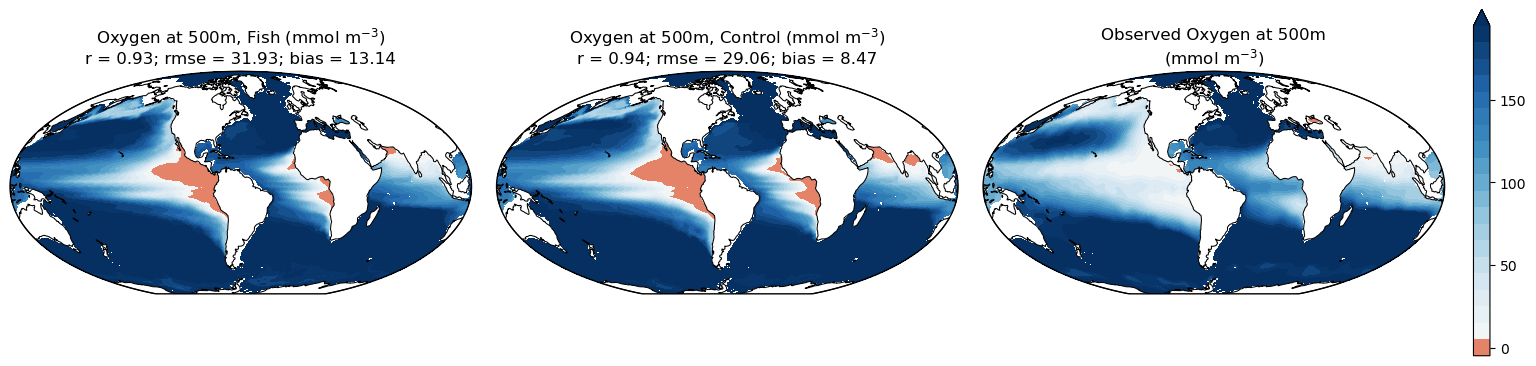

In [56]:
fig=plt.figure(figsize=(20,6))
gs=gridspec.GridSpec(1,3, wspace=0.05, width_ratios=[1,1,1.25])

ax={};cs={}

fs = 12 #fontsize

cmin = -2; cmax = 0.5; cint = 0.05
levels=np.arange(cmin,cmax,cint)

###########################################################################
# oxygen                                                                     #
###########################################################################
cmin=-5; cmax=200; cint=10
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds.o2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=5.), extend='max', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Oxygen at 500m, '+case['label']+' (mmol m$^{-3}$)\nr = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=dc.o2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=5.), extend='max', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Oxygen at 500m, Control (mmol m$^{-3}$)\nr = ' + str(np.round(r_c_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_c_o2,2)) + \
                 '; bias = ' + str(np.round(bias_c_o2,2)), fontsize=fs)

i=2
ax[i]=plt.subplot(gs[0,2],projection=ccrs.Mollweide(central_longitude=300.0))
field=o2_obs.O2_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=5.), extend='max', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Oxygen at 500m\n(mmol m$^{-3}$)', fontsize=fs)
cbar=plt.colorbar(cs[i], ticks=[0,50,100,150,200,250,300], shrink=0.75)

In [57]:
# fig=plt.figure(figsize=(20,6))
# gs=gridspec.GridSpec(1,3, wspace=0.05, width_ratios=[1,1,1.25])

# ax={};cs={}

# fs = 12 #fontsize

# cmin = -2; cmax = 0.5; cint = 0.05
# levels=np.arange(cmin,cmax,cint)

# ###########################################################################
# # oxygen                                                                     #
# ###########################################################################
# cmin=0; cmax=290; cint=10
# levels=np.arange(cmin,cmax,cint)

# i=0
# ax[i]=plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
# field=ds.o2
# cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=60.), extend='max', levels=levels, cmap='RdBu')
# ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
# ax[i].set_title('Oxygen at 500m, GZ-COBALT (mmol m$^{-3}$)\nr = ' + str(np.round(r_o2,2)) + \
#                  '; rmse = ' + str(np.round(rmse_o2,2)) + \
#                  '; bias = ' + str(np.round(bias_o2,2)), fontsize=fs)

# i=1
# ax[i]=plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
# field=dc.o2
# cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=5.), extend='max', levels=levels, cmap='RdBu')
# ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
# ax[i].set_title('Oxygen at 500m, Control (mmol m$^{-3}$)\nr = ' + str(np.round(r_c_o2,2)) + \
#                  '; rmse = ' + str(np.round(rmse_c_o2,2)) + \
#                  '; bias = ' + str(np.round(bias_c_o2,2)), fontsize=fs)

# i=2
# ax[i]=plt.subplot(gs[0,2],projection=ccrs.Mollweide(central_longitude=300.0))
# field=o2_obs.O2_woa18
# cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=5.), extend='max', levels=levels, cmap='RdBu')
# ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
# ax[i].set_title('Observed Oxygen at 500m\n(mmol m$^{-3}$)', fontsize=fs)
# cbar=plt.colorbar(cs[i], ticks=[0,50,100,150,200,250,300], shrink=0.75)

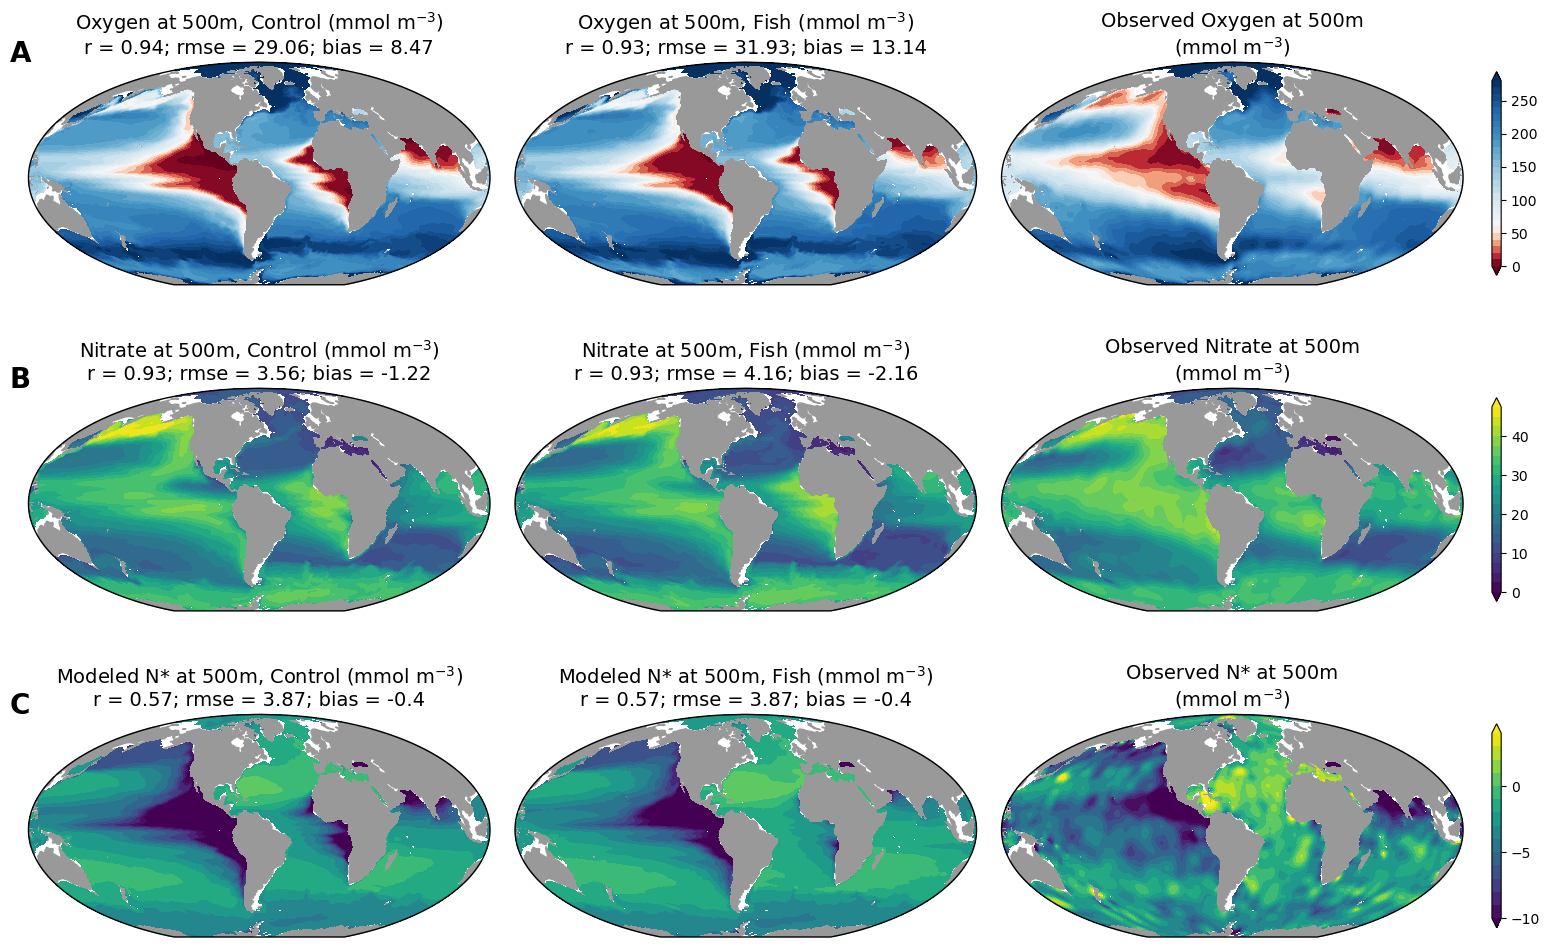

In [58]:
fig=plt.figure(figsize=(20,12))
gs=gridspec.GridSpec(3,3, wspace=0.05, width_ratios=[1,1,1.25])

ax={};cs={}

fs = 14 #fontsize

###########################################################################
# oxygen                                                                     #
###########################################################################
cmin=0; cmax=290; cint=10
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=dc.o2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=60.), extend='both', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')
ax[i].text(-0.04, 1.1, 'A', transform=ax[i].transAxes, fontsize=20, fontweight='bold', va='top')
ax[i].set_title('Oxygen at 500m, Control (mmol m$^{-3}$)\nr = ' + str(np.round(r_c_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_c_o2,2)) + \
                 '; bias = ' + str(np.round(bias_c_o2,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds.o2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=60.), extend='both', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')
ax[i].set_title('Oxygen at 500m, '+case['label']+' (mmol m$^{-3}$)\nr = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)), fontsize=fs)

i=2
ax[i]=plt.subplot(gs[0,2],projection=ccrs.Mollweide(central_longitude=300.0))
field=o2_obs.O2_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=60.), extend='both', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')
ax[i].set_title('Observed Oxygen at 500m\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,50,100,150,200,250,300], shrink=0.75)

###########################################################################
# no3                                                                     #
###########################################################################
cmin=0; cmax=50; cint=2.5
levels=np.arange(cmin,cmax,cint)

i=3
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=dc.no3
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')
ax[i].text(-0.04, 1.1, 'B', transform=ax[i].transAxes, fontsize=20, fontweight='bold', va='top')
ax[i].set_title('Nitrate at 500m, Control (mmol m$^{-3}$)\nr = ' + str(np.round(r_c_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_c_no3,2)) + \
                 '; bias = ' + str(np.round(bias_c_no3,2)), fontsize=fs)

i=4
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=ds.no3
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')
ax[i].set_title('Nitrate at 500m, '+case['label']+' (mmol m$^{-3}$)\nr = ' + str(np.round(r_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_no3,2)) + \
                 '; bias = ' + str(np.round(bias_no3,2)), fontsize=fs)


i=5
ax[i]=plt.subplot(gs[1,2],projection=ccrs.Mollweide(central_longitude=300.0))
field=no3_obs.nitrate_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')
ax[i].set_title('Observed Nitrate at 500m\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,10,20,30,40,50], shrink=0.75)

###########################################################################
# N star                                                                  #
###########################################################################
cmin = -10; cmax = 5; cint = 1
levels=np.arange(cmin,cmax,cint)

i=6
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Mollweide(central_longitude=300.0))
field=c_N_star
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')
ax[i].text(-0.04, 1.1, 'C', transform=ax[i].transAxes, fontsize=20, fontweight='bold', va='top')
ax[i].set_title('Modeled N* at 500m, Control (mmol m$^{-3}$)\nr = ' + str(np.round(r_c_N_star,2)) + \
                 '; rmse = ' + str(np.round(rmse_c_N_star,2)) + \
                 '; bias = ' + str(np.round(bias_c_N_star,2)), fontsize=fs)

i=7
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Mollweide(central_longitude=300.0))
field=N_star
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')
ax[i].set_title('Modeled N* at 500m, '+case['label']+' (mmol m$^{-3}$)\nr = ' + str(np.round(r_c_N_star,2)) + \
                 '; rmse = ' + str(np.round(rmse_c_N_star,2)) + \
                 '; bias = ' + str(np.round(bias_c_N_star,2)), fontsize=fs)


i=8
ax[i]=plt.subplot(gs[2,2],projection=ccrs.Mollweide(central_longitude=300.0))
field=N_star_obs
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
#ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#ax[i].text(0.05, 0.95, alphabet[i], transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')
ax[i].set_title('Observed N* at 500m\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[-10,-5,0,5], shrink=0.75)

plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates[0]+'_500m_Nutrients.png', dpi=300, bbox_inches='tight')